*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection dataset](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.


In [1]:
# Importar librerías.
try:
  # %tensorflow_version solo existe en Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.5.0-dev20210203


In [2]:
# Obtener los archivos con los datos
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2021-02-03 14:30:43--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/tab-separated-values]
Saving to: ‘train-data.tsv.4’

train-data.tsv.4        [ <=>                ] 349.84K  --.-KB/s    in 0.04s   

2021-02-03 14:30:43 (8.10 MB/s) - ‘train-data.tsv.4’ saved [358233]

--2021-02-03 14:30:43--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/tab-separated-values]
Saving to: ‘valid-data.tsv.4’

valid-data.tsv.4        [ <=>               

Firstly, we are going to read the train dataset that we have downloaded and we are gonna see its first 5 rows:

In [3]:
# Se lee el archivo de entrenamiento mediante el método 'read_csv' de pandas.
df_train = pd.read_csv(train_file_path, sep="\t", header=None, names=['y', 'x']) # @sep: Separador de palabras. En este caso, el 
                                                                                 # tabulador.
                                                                                 # @header: Número de la fila para usar como nombre
                                                                                 # de las columnas. En este caso, ninguna.
                                                                                 # @names: Nombres de las columnas.
df_train.head() # @head: Devuelve las 5 primeras filas

,y,x
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


Now we do the same with the test dataframe: read the test dataset and see its first five rows.

In [4]:
# Se lee el archivo de test mediante el método 'read_csv' de pandas.
df_test = pd.read_csv(test_file_path, sep="\t", header=None, names=['y', 'x']) # @sep: Separador de palabras. En este caso, el 
                                                                               # tabulador.
                                                                               # @header: Número de la fila para usar como nombre
                                                                               # de las columnas. En este caso, ninguna.
                                                                               # @names: Nombres de las columnas.
df_test.head() # @head: Devuelve las 5 primeras filas

,y,x
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


Now that we have read both training and test files, it's time to convert the categorical values (from the labels column) of the train dataframe to numbers using the *label encoding* technique. We save the numerical values in the `y_train` variable.

In [5]:
# En esta ocasión, para convertir los valores categóricos en numéricos no utilizamos el método @get_dummies como en el problema
# anterior, el cual creaba varias columnas dependiendo del número de variables categóricas que había. Esta vez usamos el método 
# @cat.codes para convertir en la misma columna los datos categóricos a numéricos.

# @astype: Asigna las columnas seleccionadas al tipo seleccionado ('category').
# @cat.codes: Transforma los datos categóricos en numéricos (por orden alfabético) usando la técnica del label encoding.
y_train = df_train['y'].astype('category').cat.codes
y_train.head()

0    0
1    0
2    0
3    0
4    0
dtype: int8

Now we do the same with the test dataframe and save the results in the `y_test` variable.

In [6]:
# En esta ocasión, para convertir los valores categóricos en numéricos no utilizamos el método @get_dummies como en el problema
# anterior, el cual creaba varias columnas dependiendo del número de variables categóricas que había. Esta vez usamos el método 
# @cat.codes para convertir en la misma columna los datos categóricos a numéricos.

# @astype: Asigna las columnas seleccionadas al tipo seleccionado ('category').
# @cat.codes: Transforma los datos categóricos en numéricos (por orden alfabético) usando la técnica del label encoding.
y_test = df_test['y'].astype('category').cat.codes
y_test.head()

0    0
1    0
2    0
3    0
4    0
dtype: int8

After that we can make a word cloud from the spam and ham messages in the train dataframe, just only to view a visual representation of text data. The bigger the word is, the more frequently it appears in the dataset.

At first place, we are going to plot the word cloud of the spam label:

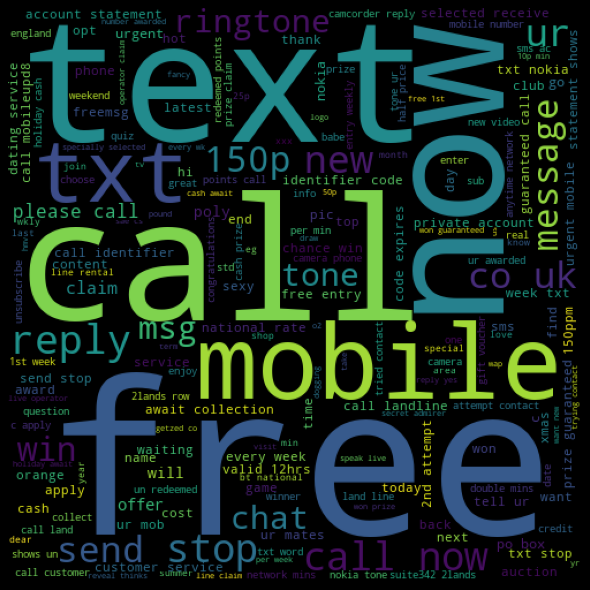

In [7]:
# Librería para crear nubes de palabras.
from wordcloud import WordCloud

spam_words = ' '.join(list(df_train[df_train['y']=='spam']['x'])) # Recoge todas las palabras que aparecen en la columna 'x' cuando la
                                                             # columna 'y' vale 1, es decir, cuando hay spam.
spam_wc = WordCloud(width = 500,height = 500).generate(spam_words) # Instancia de Worcloud para generar y dibujar con la anchura
                                                                   # y altura específicadas la nube de palabras a partir del texto.
                                                                   # @generate: Genera la nube de palabras a partir del texto de
                                                                   # 'spam_words'.
plt.figure(figsize = (10, 8), facecolor = 'k') # Crea una nueva figura con la anchura, altura y color de fondo específicados. 
plt.imshow(spam_wc) # Muestra los datos en forma de imagen.
plt.axis('off') # No muestra ni ejes ni etiquetas.
plt.tight_layout(pad = 0) # Relleno entre el borde de la figura.
plt.show() # Muestra todas las figuras.

And now, we are going to plot the word cloud of the ham label:

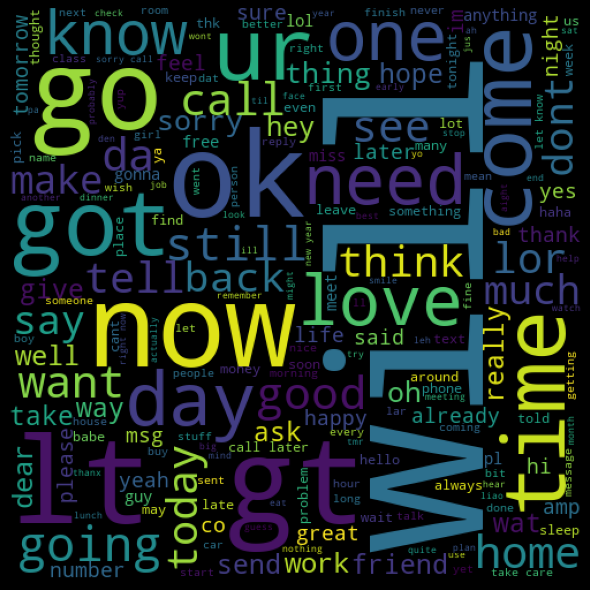

In [8]:
ham_words = ' '.join(list(df_train[df_train['y']=='ham']['x'])) # Recoge todas las palabras que aparecen en la columna 'x' cuando la
                                                            # columna 'y' vale 0, es decir, cuando no hay spam.
ham_wc = WordCloud(width = 500,height = 500).generate(ham_words) # Instancia de Worcloud para generar y dibujar con la anchura
                                                                   # y altura específicadas la nube de palabras a partir del texto.
                                                                   # @generate: Genera la nube de palabras a partir del texto de
                                                                   # 'ham_words'.
plt.figure(figsize = (10, 8), facecolor = 'k') # Crea una nueva figura con la anchura, altura y color de fondo específicados.
plt.imshow(ham_wc) # Muestra los datos en forma de imagen.
plt.axis('off') # No muestra ni ejes ni etiquetas.
plt.tight_layout(pad = 0) # Relleno entre el borde de la figura.
plt.show() # Muestra todas las figuras.

Now we are going to preprocess the text of the dataframe. For that purpose, we are going to lemmatize the column `x` of the dataframe, so we get the lemma of every single word (the canonical form of a set of words). In addition, we are going to remove the stop words, that are words that don't have a meaning (like articles or prepositions). Once we do that, we save the results in the `X_train` variable.

In [9]:
import nltk # Se importa el kit de herramientas para el procesamiento del lenguaje natural.

nltk.download('stopwords') # Descarga la base de datos de palabras vacías en inglés.
nltk.download('wordnet') # Descarga la base de datos de lemas en inglés.
nltk.download('averaged_perceptron_tagger') # Descarga del algoritmo que predice el tipo de palabra según su contexto en la frase.

from nltk.stem import WordNetLemmatizer # Librería para implementar lematización.
from nltk.corpus import wordnet # Librería para buscar palabras en la base de datos de lemas.
from nltk.corpus import stopwords # Librería para implementar palabras vacías.

# Se define una función para conocer el contexto de la palabra a la que se le va a extraer el lema (lingüística). Es decir, para 
# saber si esa palabra es un nombre, un adverbio, un verbo o un adjetivo.
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper() # @post_tag: Evalúa que tipo de palabra es la palabra (argumento) 'word'.
    tag_dict = {"J": wordnet.ADJ, 
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN) # Devuelve que tipo de palabra es 'word' según la clave del diccionario.
                                           # En caso que la clave no exista, se devuelve por defecto el tipo NOUN.
  
wnl = WordNetLemmatizer() # Se inicia la instancia para comenzar el proceso de lematización.
stop_words = set(stopwords.words('english')) # Establece como palabras vacías las palabras de la base de datos descargada.  

output_train_X = [] # Se crea un array para el dataset de entrenamiento

# Para cada fila dentro de la columna 'x' del dataframe se extrae el lema de cada palabra teniendo en cuenta si se trata
# de un verbo, adjetivo, etc, ayudándonos de la función creada arriba y asegurándonos que cada una de las palabras esté 
# en minúsculas. Además, solo nos quedamos con las palabras importantes, puesto que se eliminan las palabras vacías de 
# la base de datos que descargamos anteriormente. Todo esto se añade en el array creado.
for sentence in df_train['x']:
    output_train_X.append(" ".join([wnl.lemmatize(word.lower(),get_wordnet_pos(word)) for word in sentence.split() 
    if not word in stop_words]))

X_train = output_train_X # Hacemos que 'X_train' tenga los valores almacenados en el array.
X_train[:5] # Imprimimos los 5 primeros valores de 'X_train'.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


['ahhhh...just woken up!had bad dream u tho,so dont like u right :) didnt know anything comedy night guess im it.',
 'never nothing',
 'u sound like manky scouse boy steve,like! travel da bus home.wot u inmind 4 recreation dis eve?',
 'mum say wan go go... shun bian watch da glass exhibition...',
 'never lei... v lazy... get wat? dat day ü send da url cant work one...']

Now we do exactly the same with the test dataframe, storing the results in the `X_test` variable.

In [10]:
output_test_X = [] # Se crea un array para el dataset de test

# Para cada fila dentro de la columna 'x' del dataframe se extrae el lema de cada palabra teniendo en cuenta si se trata
# de un verbo, adjetivo, etc, ayudándonos de la función creada en la celda anterior y asegurándonos que cada una de las palabras 
# esté en minúsculas. Nos quedamos también solamente con las palabras importantes, puesto que se eliminan las palabras vacías de 
# la base de datos que descargamos. Todo esto se añade en el array creado.
for sentence in df_test['x']:
    output_test_X.append(" ".join([wnl.lemmatize(word.lower(),get_wordnet_pos(word)) for word in sentence.split() 
    if not word in stop_words]))

X_test = output_test_X # Hacemos que 'X_test' tenga los valores almacenados en el array.
X_test[:5] # Imprimimos los 5 primeros valores del dataset de 'X_test'.

['hospital da. . return home even',
 "much, textin'. bout you?",
 "probably eat today. think i'm gonna pop. weekend? u miss me?",
 'don‘t give fly monkey wot think certainly don‘t mind. friend mine that!',
 'seeing?']

Once the text is preprocessed it's time to tokenize and encode the `X_train` variable. With the tokenization we split every sentence into words while the encoding transform every word into a unique number. 

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer # Clase de TensorFlow para tokenizar texto que contiene una función
                                                          # para vectorizar palabras en números, que es la que se va a utilizar.
num_words = 2000
tokenizer = Tokenizer(num_words) # Se inicia la instancia para comenzar el proceso de vectorización manteniendo las 2000 palabras
                                 # más usadas.
tokenizer.fit_on_texts(X_train) # @fit_on_texts: Actualiza el vocabulario interno basado en el texto encontrado en 'X_train'.
                                # (requerido antes de usar @texts_to_sequences).
X_train = tokenizer.texts_to_sequences(X_train) # @texts_to_sequences: Transforma cada palabra en un número entero.
X_train[:5]

[[851,
  202,
  1778,
  252,
  377,
  1,
  610,
  258,
  48,
  15,
  1,
  100,
  378,
  14,
  119,
  1468,
  62,
  216,
  95,
  34],
 [208, 267],
 [1, 327, 15, 259, 15, 1085, 49, 328, 44, 409, 1, 9, 357, 445],
 [611, 24, 203, 4, 4, 125, 49],
 [208, 500, 188, 852, 2, 90, 243, 18, 33, 23, 49, 1469, 142, 60, 30]]

Again, we do the same with the `X_test` variable.

In [12]:
X_test = tokenizer.texts_to_sequences(X_test) # @texts_to_sequences: Transforma cada palabra en un número entero.
X_test[:5]

[[1618, 49, 641, 44, 118],
 [68, 695, 22],
 [306, 220, 35, 42, 6, 145, 282, 1, 63, 29],
 [69, 409, 42, 235, 93, 736, 254],
 []]

Once the dataframes are tokenized and encoded, we need to paddle the numbers, because we cannot pass different length data into our neural network. Therefore, we must make each word the same length.

In [13]:
from keras.preprocessing import sequence # Módulo para procesar secuencias de datos, como puede ser un dataframe.

max_len = 20

X_train = sequence.pad_sequences(X_train, maxlen=20) # @pads_sequences: Ajusta las secuencias a la misma longitud (20). Si la
                                                   # secuencia es más corta de 20, se rellena con 0's; y si es más larga, se
                                                   # recortan los números sobrantes. 
X_train[:5]

array([[ 851,  202, 1778,  252,  377,    1,  610,  258,   48,   15,    1,
         100,  378,   14,  119, 1468,   62,  216,   95,   34],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  208,  267],
       [   0,    0,    0,    0,    0,    0,    1,  327,   15,  259,   15,
        1085,   49,  328,   44,  409,    1,    9,  357,  445],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  611,   24,  203,    4,    4,  125,   49],
       [   0,    0,    0,    0,    0,  208,  500,  188,  852,    2,   90,
         243,   18,   33,   23,   49, 1469,  142,   60,   30]],
      dtype=int32)

In [14]:
X_test = sequence.pad_sequences(X_test, maxlen=20) # @pads_sequences: Ajusta las secuencias a la misma longitud (20). Si la
                                                   # secuencia es más corta de 20, se rellena con 0's; y si es más larga, se
                                                   # recortan los números sobrantes.
X_test[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 1618,   49,  641,   44,  118],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,   68,  695,   22],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  306,
         220,   35,   42,    6,  145,  282,    1,   63,   29],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   69,  409,   42,  235,   93,  736,  254],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int32)

Now that we have padded the numbers, we are in conditions to create the model we are going to train. To do so, we use a recurrent neural network, that are the best for natural language processing.

In [15]:
from tensorflow.keras import layers # API de Keras para utilizar las capas que conforman una red neuronal.

model = tf.keras.Sequential() # @Sequential: Agrupa una serie de capas en el modelo de la red neuronal.
model.add(layers.Embedding(input_dim=num_words, output_dim=32, input_length=max_len)) # Transforma los enteros positivos en vectores
                                                                                      # densos de tamaño fijo (32 dimensiones). Esta 
                                                                                      # capa solo puede ser usada como primera capa.
model.add(layers.LSTM(32)) # Capa LSTM con una dimensionalidad del espacio de salida de 32.
model.add(layers.Dense(1, activation="sigmoid")) # Capa de clasificación con solo una neurona y activación 'sigmoid' (solo 2 clases).
model.summary() # Resumen del modelo de red.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 32)            64000     
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 72,353
Trainable params: 72,353
Non-trainable params: 0
_________________________________________________________________


Now that we have created and defined our model it's time to compile it. To do so, we define a loss function and a optimizer:

- The loss function is the function used to estimate the loss of the model.
- The optimizer change the parameters of the neural network with the goal of minimizing the loss function.

The goal is to reach the global minimum of the loss function, so that the neural network is perfect.

In [16]:
model.compile(loss='binary_crossentropy', # Esta función de loss se suele usar para problemas de clasificación binaria como el actual.
              optimizer=keras.optimizers.Adam(lr = 0.01), # Optimizador para actualizar los pesos y sesgos de la red neuronal.
                                                             # lr: Learning rate (tamaño de los pasos para alcanzar el mínimo global 
                                                             # de la función de loss).
              metrics=['accuracy']) # Se utiliza la precisión como métrica para evaluar el rendimiento del modelo. Calcula con qué
                                    # frecuencia las predicciones son iguales a las etiquetas ('y_train').

As we can see above, we have defined as a metric the accuracy, so we can evaluate the performance of the model with this metric.

Once the model has been compiled, we only have to train it using the `fit` method.

In [17]:
history = model.fit(x=X_train, # Datos de entrada.
                    y=y_train, # Datos de salida.
                    epochs=30, # Número de iteraciones sobre el dataset para entrenar el modelo.
                    verbose=2, # Barra de progreso de entrenamiento.
                    validation_split=0.2) # Fracción de los datos de entrenamiento que van a ser usados como datos de validación.

Epoch 1/30
105/105 - 4s - loss: 0.1089 - accuracy: 0.9689 - val_loss: 0.0472 - val_accuracy: 0.9904
Epoch 2/30
105/105 - 1s - loss: 0.0276 - accuracy: 0.9925 - val_loss: 0.0480 - val_accuracy: 0.9904
Epoch 3/30
105/105 - 1s - loss: 0.0126 - accuracy: 0.9970 - val_loss: 0.0504 - val_accuracy: 0.9892
Epoch 4/30
105/105 - 1s - loss: 0.0082 - accuracy: 0.9982 - val_loss: 0.0498 - val_accuracy: 0.9916
Epoch 5/30
105/105 - 1s - loss: 0.0040 - accuracy: 0.9988 - val_loss: 0.0561 - val_accuracy: 0.9892
Epoch 6/30
105/105 - 1s - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0569 - val_accuracy: 0.9916
Epoch 7/30
105/105 - 1s - loss: 0.0021 - accuracy: 0.9997 - val_loss: 0.0617 - val_accuracy: 0.9916
Epoch 8/30
105/105 - 1s - loss: 0.0023 - accuracy: 0.9991 - val_loss: 0.0620 - val_accuracy: 0.9904
Epoch 9/30
105/105 - 1s - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.0625 - val_accuracy: 0.9916
Epoch 10/30
105/105 - 1s - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.0640 - val_accuracy: 0.9916

Once the model has been trained, we can evaluate the model in test mode to see how well it performs.

In [18]:
results = model.evaluate(X_test,y_test) # Devuelve los valores de la loss y de la métrica seleccionada anteriormente (precisión) 
                                        # para el modelo en modo test.
print(results)

44/44 [==============================] - 0s 4ms/step - loss: 0.1246 - accuracy: 0.9871
[0.12457805126905441, 0.9870689511299133]


As we can see above, the model has a very great performance, cause its accuracy is 98.7%.

Once the model has been evaluated we define a function to encode a single sentence. In this way, the function gets a single sentence, tokenizes it, erase its stop words and transform every one of its remaining words into a sequence of unique integer numbers.

In [19]:
# Para la frase pasada como argumento en la función se extrae el lema de cada palabra teniendo en cuenta si se trata de un verbo,
# adjetivo, etc, ayudándonos de la función creada anteriormente y asegurándonos que cada una de las palabras esté en minúsculas. 
# Nos quedamos solo con las palabras importantes, puesto que se eliminan las palabras vacías de la base de datos que descargamos. 
# Todo esto se añade al array creado y posteriormente hacemos que la frase pasada como argumento obtenga los valores del array.
def encode(X):
  output = [] # Se crea un array vacío.
  output.append(" ".join(wnl.lemmatize(word.lower(),get_wordnet_pos(word)) for word in X.split() 
    if not word in stop_words))
  X = output # Hacemos que la variable donde estaba almacenada la frase tenga ahora la misma frase pero tokenizada y sin palabras 
  # vacías, tal y como se ha almacenado en el array.
  X = tokenizer.texts_to_sequences(X) # Transforma cada palabra de la frase en un número entero único.
  return sequence.pad_sequences(X, maxlen=max_len) # La función devuelve la secuencia de números enteros con una longitud de 20.

print(encode("how are you doing today?")) # Ejemplo para comprobar que funciona bien.

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 35]]


Now that we have a function to decode a sentence into a sequence of twenty numbers, we can make a prediction and get the label of a single sentence.

In [20]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
pred_text = "how are you doing today?"

def predict_message(pred_text):
    p = model.predict(encode(pred_text)) # Se codifica en números enteros la frase almacenada en 'pred_text' con la función de arriba.
    return ('%.2f'%(p), "ham" if p<=0.5 else "spam") # Se devuelve la predicción (con dos decimales) y la etiqueta (label).

prediction = predict_message(pred_text)
print(prediction)

('0.00', 'ham')


Finally, we run the last cell to check if we pass the challenge or not.

In [21]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers): # @zip: Toma como argumento dos objetos iterables (una frase de 'test_messages' 
                                                    # y una predicción de 'test_answers') y retorna un nuevo iterable cuyos
                                                    # dos elementos son tuplas que contienen una frase de 'test_messages' y una
                                                    # predicción de 'test_answers'. Ej: [('how are you doing today', 'ham')].
    prediction = predict_message(msg) # Se utiliza la función definida en la celda anterior para predecir si las frases son spam o no.
    if prediction[1] != ans: # Si la predicción es distinta de la respuesta...
      passed = False # ... No se pasa la prueba.

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()

You passed the challenge. Great job!
